In [1]:
#loading all the libraries and dependencies

import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

Using TensorFlow backend.


In [2]:
#Importing our data from Kaggle
os.environ['KAGGLE_CONFIG_DIR']='/content/'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:56<00:00, 48.5MB/s]
100% 2.29G/2.29G [00:56<00:00, 43.8MB/s]


In [0]:
#Extracting the datasets
import zipfile

local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
# Specifying the path of the data(train,test,validaton)
input_path="/content/chest_xray"
train = "/content/chest_xray/train"
test = "/content/chest_xray/test"
val = "/content/chest_xray/val"

In [0]:
# Here we have backended keras to tensorflow ,so we go for channel_last ie to specify
#the channel value as the last dimension in shape of the input.
img_width,img_height= 150,150
input_shape = (img_width,img_height,3)

In [0]:
# ImageDataGenerator-Generate batches of tensor image data with real-time data augmentation. 
#The data will be looped over (in batches).

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   ,horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
# Here we import images directly from Directory by using flow_from_directory method.
#flow_from_directory() automatically infers the labels from the directory structure of the folders containing images

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
#Creating Model
#It’s just a thing function that you use to get the output of node. It is also known as Transfer Function.
inputs = Input(shape=(150, 150, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True, min_delta=0.1, patience=1, mode='min')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
#Gives the summary of the layers used to create our model 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

In [11]:
batch_size=32
epochs=10

hist = model.fit_generator(
           train_generator, 
           steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_generator, 
           validation_steps=test_generator.samples // batch_size, 
           callbacks=[checkpoint, lr_reduce])



Epoch 1/10
163/163 [==============================] - 191s 1s/step - loss: 0.3742 - acc: 0.8378 - val_loss: 0.7359 - val_acc: 0.5132
Epoch 2/10
163/163 [==============================] - 185s 1s/step - loss: 0.2771 - acc: 0.8907 - val_loss: 0.6261 - val_acc: 0.6941
Epoch 3/10
163/163 [==============================] - 187s 1s/step - loss: 0.2417 - acc: 0.9122 - val_loss: 0.4561 - val_acc: 0.7697

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 185s 1s/step - loss: 0.1888 - acc: 0.9279 - val_loss: 0.3314 - val_acc: 0.8980
Epoch 5/10
163/163 [==============================] - 187s 1s/step - loss: 0.1558 - acc: 0.9433 - val_loss: 0.2934 - val_acc: 0.9112

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 185s 1s/step - loss: 0.1573 - acc: 0.9471 - val_loss: 0.2859 - val_acc: 0.9013
Epoch 7/10
163/163 [==================

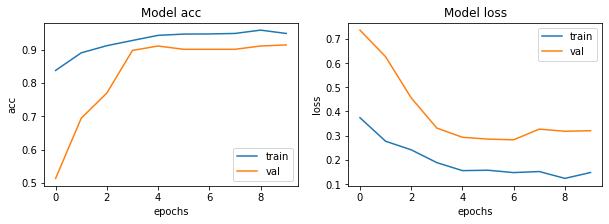

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [0]:
#Saving our model in keras format
model.save('my_model.pb')